In [1]:
! pip install kaggle
#https://www.kaggle.com/code/ravishekhartiwari123/explainable-ai-on-a-nlp-lstm-model-with-lime/edit
#https://www.kaggle.com/code/alikmondal/twitter-hate-speech-detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-11-17 05:23:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-17 05:23:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-17 05:23:28--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp /content/drive/MyDrive/credentials/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 /content/.kaggle/kaggle.json

chmod: cannot access '/content/.kaggle/kaggle.json': No such file or directory


In [6]:

! kaggle datasets download vkrahul/twitter-hate-speech

100% 1.89M/1.89M [00:01<00:00, 1.42MB/s]
100% 1.89M/1.89M [00:01<00:00, 1.25MB/s]


In [7]:
! unzip /content/twitter-hate-speech.zip 

Archive:  /content/twitter-hate-speech.zip
  inflating: test_tweets_anuFYb8.csv  
  inflating: train_E6oV3lV.csv       


In [8]:
!pip install tweet-preprocessor
!pip install nltk
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.7 MB/s 


In [9]:
%matplotlib inline

import os
import re
import nltk
import demoji
import warnings
import pandas as pd
import seaborn as sns
import tensorflow as tf
import preprocessor as p
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")

In [10]:
nltk.download('all')
demoji.download_codes()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

In [11]:
train = pd.read_csv("/content/train_E6oV3lV.csv")
test = pd.read_csv("/content/test_tweets_anuFYb8.csv")

In [12]:



def upsample(dataframe):
  
  print("Before Upsampling::",train['label'].value_counts())
  train_majority = dataframe[dataframe.label==0]
  train_minority = dataframe[dataframe.label==1]
  train_minority_upsampled = resample(train_minority, 
                                      replace=True,    
                                        n_samples=len(train_majority),   
                                        random_state=123)
  
  train_upsampled = pd.concat([train_minority_upsampled, train_majority])
  print("Sfter Upsampling::",train['label'].value_counts())
  return(train_upsampled)


train_upsampled=upsample(train)

Before Upsampling:: 0    29720
1     2242
Name: label, dtype: int64
Sfter Upsampling:: 0    29720
1     2242
Name: label, dtype: int64


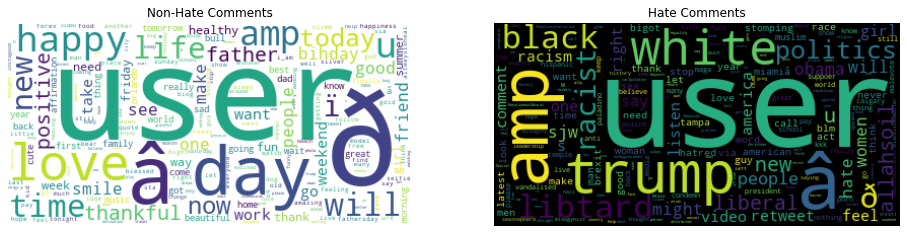

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train['tweet'][train.label == 0])
text_neg = " ".join(train['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

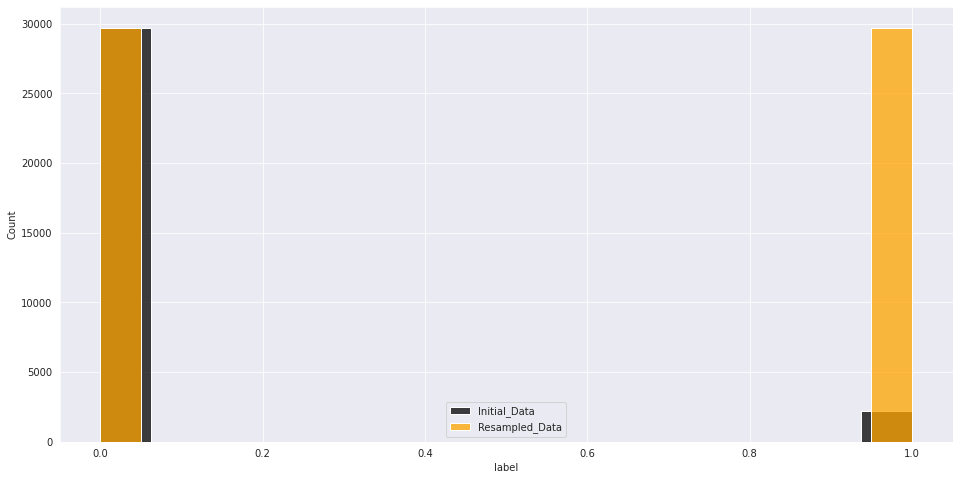

In [14]:


plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.histplot(data = train['label'], color='black', legend=True)
sns.histplot(data = train_upsampled['label'], color = 'orange', legend=True)
plt.legend(['Initial_Data', 'Resampled_Data'])
plt.show()

In [ ]:
class preproceessing():
    
    def __init__(self,x,y,algo='BOG'):
      self.x=x
      self.y=y
      self.algo=algo

    def noemoji(self, data):
        dem = demoji.findall(str(data))
        for item in dem.keys():
          data = data.replace(item,'')
        return(data)

    def remove_punctuation(self,data):
        return(re.sub(r'[^\w\s]', '', str(data)))
    
    def preprocessing_twitter(self,data):
        data1=p.clean(str(data))
        return(data1)
    
    def tokenise_data(self,data):
        return(word_tokenize(data))

    def remove_stopwords(self,data):
        stop_words = set(stopwords.words('english'))
        return ([i for i in data if not i.lower() in stop_words])

    
    def stemming(self,data):
        ps = PorterStemmer()
        data1=""
        for w in data:
          data1=data1+" "+ps.stem(w)
        return(data1)

    def bog(self,data):
        vectorizer = CountVectorizer(max_features=512)
        bog_data=vectorizer.fit_transform(data)
        return(bog_data.toarray())

    def tf_idf(self,data):
        vectorizer = TfidfVectorizer(analyzer= 'word')
        tfidf_data=vectorizer.fit_transform(data)
        return(tfidf_data.toarray())
    
    def wrapper(self):
      data={
             "X":self.x,
             "Y":self.y
           }
      new_data = pd.DataFrame.from_dict(data)

      preprocessed=new_data["X"].apply(self.noemoji).apply(self.remove_punctuation).apply(self.preprocessing_twitter).apply(self.tokenise_data).apply(self.remove_stopwords).apply(self.stemming)

      if self.algo=='BOG':
        data_return=self.bog(preprocessed.values)
        return(data_return,self.y)
      elif self.algo=='TFIDF':
        data_return=self.tf_idf(preprocessed.values)
        return(data_return,self.y)            
 
        
    ## preprocessing end




# a=preproceessing(train['tweet'],train['label'])
# b=a.wrapper()



In [ ]:
#functions 

import math
import numpy as np
class preprocessingSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size=32):
        
       
        obj_preprocessing=preproceessing(x_set, y_set)
        a,b=obj_preprocessing.wrapper()
        self.x, self.y = list(a),list(b)
        self.batch_size = batch_size
    
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    

    def __getitem__(self, idx):

        batch_x = self.x[idx * self.batch_size:(idx + 1) *self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
       
        
        return np.array(batch_x),np.array(batch_y)
 
    

In [15]:
#functions 


def noemoji(data):
  dem = demoji.findall(str(data))
  for item in dem.keys():
    data = data.replace(item,'')
  return(data)



def remove_punctuation(data):
    return(re.sub(r'[^\w\s]', '', str(data)))

def preprocessing_twitter(data):
  data1=p.clean(str(data))
  return(data1)

def tokenise_data(data):
  return(word_tokenize(data))

def remove_stopwords(data):
  stop_words = set(stopwords.words('english'))
  return ([i for i in data if not i.lower() in stop_words])

ps = PorterStemmer()
def stemming(data):
  data1=""
  for w in data:
    data1=data1+" "+ps.stem(w)
  return(data1)

  

In [16]:
#function TExt to Numerics

def bog(data):
    vectorizer = CountVectorizer(max_features=512)
    bog_data=vectorizer.fit_transform(data)
    return([bog_data.toarray(),vectorizer.get_feature_names_out(),vectorizer])


def tf_idf(data):
    vectorizer = TfidfVectorizer(analyzer= 'word')
    tfidf_data=vectorizer.fit_transform(data)
    return([tfidf_data.toarray(),vectorizer.get_feature_names_out(),vectorizer])


def glove(data):
  pass




In [17]:
tweets_preprocessed=train['tweet'].apply(noemoji).apply(remove_punctuation).apply(preprocessing_twitter).apply(tokenise_data).apply(remove_stopwords).apply(stemming)

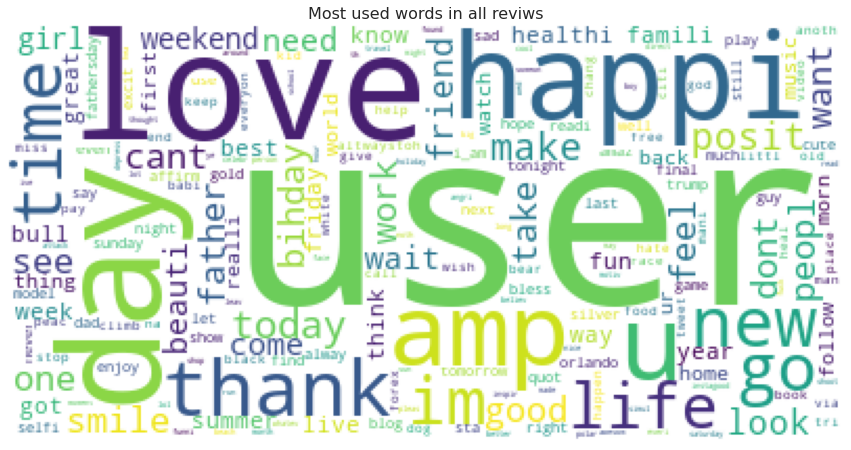

In [18]:
def join_text(data):
  #print(data)
  return(",".join(data))


from wordcloud import WordCloud
import matplotlib.pyplot as plt


train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(join_text(tweets_preprocessed))

plt.figure(figsize=(15,8))

plt.imshow(train_cloud_pos )
plt.title("Most used words in all reviws", size=16)

plt.axis("off")
plt.show()

In [19]:

bog_data= bog(tweets_preprocessed.values)
print(bog_data[0].shape)


# tfidf_data= tf_idf(tweets_preprocessed.values)
# print(tfidf_data[0].shape)

(31962, 512)


In [20]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
max_features = 512  # Only consider the top 20k words
maxlen = 26

In [ ]:
# class LSTMmodel(tf.keras.Model):
#   def __init__(self,max_feature,Lstm_neuron1,Lstm_neuron2,Dense1,Dense2)
#       self.max_feature=max_feature
#       self.Lstm_neuron1=Lstm_neuron1
#       self.Lstm_neuron2=Lstm_neuron2
#       self.Dense1=Dense1
#       self.Dense2=Dense2






In [21]:
inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(max_features, 128)(inputs)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(32)(x)
x = layers.Dense(25, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         65536     
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 25)                825       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 218,579
Trainable params: 218,579
Non-trainable

In [ ]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy",tf.keras.metrics.AUC()])
dataset_train=preprocessingSequence(train['tweet'],train['label'])
#dataset_test=preprocessingSequence(test['tweet'])


KeyboardInterrupt: ignored

In [ ]:

model.fit_generator(generator=dataset_train,epochs=1)

NameError: ignored

In [144]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy",tf.keras.metrics.AUC()])
history=model.fit(np.asarray(bog_data[0]), np.asarray(train['label']), batch_size=128, epochs=1)#


250/250 [==============================] - 59s 66ms/step - loss: 0.2549 - accuracy: 0.9299 - auc_13: 0.4916


In [23]:
np.asarray(bog_data[0]).shape

(31962, 512)

In [24]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 27.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283858 sha256=cf5624b08336228c5e43ff775b3298d995d4e1e33300201730b8546add9a2e69
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [25]:
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters

In [26]:
explainer=lime.lime_text.LimeTextExplainer(class_names=['0','1'])

In [27]:
tweets_preprocessed1=test['tweet'].apply(noemoji).apply(remove_punctuation).apply(preprocessing_twitter).apply(tokenise_data).apply(remove_stopwords).apply(stemming)
bog_data1= bog(tweets_preprocessed.values)
print(bog_data1[0].shape)
predict=model.predict(np.asarray(bog_data1[0]))

(31962, 512)
999/999 [==============================] - 23s 22ms/step


In [28]:
tweets_preprocessed.values.shape

(31962,)

In [29]:
print(np.asarray(bog_data1[0]).shape)
print(np.expand_dims(np.asarray(bog_data1[0][7]),axis=0).shape)

(31962, 512)
(1, 512)


In [30]:
predict1=model.predict(np.expand_dims(np.asarray(bog_data1[0][7]),axis=0))

1/1 [==============================] - 0s 46ms/step


In [31]:
# predict[0]
predict_proba=[predict[0][0],1-predict[0][0]]
predict_proba

[0.079968296, 0.9200317040085793]

In [137]:
def predict123(array):
  datapreo=[]
  for i in array:

      test=stemming(remove_stopwords(tokenise_data(preprocessing_twitter(remove_punctuation(noemoji(array))))))
      datapreo.append(test)
  
  boggy=bog_data[2].transform(datapreo)    
  predict1=model.predict(np.asarray(boggy.toarray()))
  arr=[[float(1-i),float(i)] for i in model.predict(boggy.toarray())]

  print(arr)
  return(arr)

predict123([test['tweet'].iloc[5],test['tweet'].iloc[8]])


1/1 [==============================] - 0s 28ms/step
[[0.9199985861778259, 0.08000139892101288], [0.9199985861778259, 0.08000139892101288]]


[[0.9199985861778259, 0.08000139892101288],
 [0.9199985861778259, 0.08000139892101288]]

In [136]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X[:2, :])

clf.predict_proba(X[:2, :])


array([[9.81815526e-01, 1.81844595e-02, 1.44073266e-08],
       [9.71757866e-01, 2.82421043e-02, 3.01287918e-08]])

In [105]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 128
max_features = 512

import tensorflow as tf 
tf.random.set_seed(42)

def create_model(max_features):
    """ Model creation function: returns a compiled LSTM"""
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(max_features, 128)(inputs)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(32)(x)
    x = layers.Dense(25, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile("adam", "binary_crossentropy", metrics=["accuracy",tf.keras.metrics.AUC()])
    return model

In [124]:
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=32, 
                               max_features=max_features, verbose=1)

In [148]:
#tweets_preprocessed[0]
test['tweet'].iloc[9]

from sklearn.pipeline import make_pipeline

pipeline=make_pipeline(sklearn_lstm)
pipeline.fit(np.asarray(bog_data[0]), np.asarray(train['label']))

Epoch 1/2
999/999 [==============================] - 58s 55ms/step - loss: 0.2573 - accuracy: 0.9299 - auc_15: 0.4977
Epoch 2/2
999/999 [==============================] - 49s 49ms/step - loss: 0.2550 - accuracy: 0.9299 - auc_15: 0.5024


Pipeline(steps=[('kerasclassifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f44953bf790>)])

In [132]:
train['tweet']

0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
31957    ate @user isz that youuu?ðððððð...
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960    @user #sikh #temple vandalised in in #calgary,...
31961                     thank you @user for you follow  
Name: tweet, Length: 31962, dtype: object

In [114]:
np.expand_dims(np.asarray(bog_data[0][7]),axis=0).shape
pipeline.predict(np.expand_dims(np.asarray(bog_data[0][7]),axis=0))

1/1 [==============================] - 1s 1s/step


array([[0]])

In [115]:
pipeline.predict_proba(np.expand_dims(np.asarray(bog_data[0][7]),axis=0))

1/1 [==============================] - 0s 112ms/step


array([[0.92658037, 0.07341964]], dtype=float32)

In [149]:
#!pip install aix360
ab=np.expand_dims(np.asarray(bog_data[0][7]),axis=0)
ab

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [158]:

explainer = LimeTextExplainer()
#explainer=lime.lime_text.LimeTextExplainer()

In [155]:
def predict123(array):
  datapreo=[]
  for i in array:

      test=stemming(remove_stopwords(tokenise_data(preprocessing_twitter(remove_punctuation(noemoji(array))))))
      datapreo.append(test)
  
  boggy=bog_data[2].transform(datapreo)  
  arr=pipeline.predict_proba(boggy.toarray())
    
  # predict1=model.predict(np.asarray(boggy.toarray()))
  # arr=[[float(1-i),float(i)] for i in model.predict(boggy.toarray())]

  print(arr)
  return(pipeline.predict_proba(boggy.toarray()))

acv=predict123([test['tweet'].iloc[5],test['tweet'].iloc[8]])

1/1 [==============================] - 0s 50ms/step
[[0.9248979  0.07510212]
 [0.9248979  0.07510212]]
1/1 [==============================] - 0s 49ms/step


In [166]:
exp = explainer.explain_instance(test['tweet'][34],  predict123, num_features=62, num_samples=50)


2/2 [==============================] - 0s 24ms/step
[[0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284]
 [0.9248472  0.07515284

In [167]:
exp.show_in_notebook(text=test['tweet'][34] )

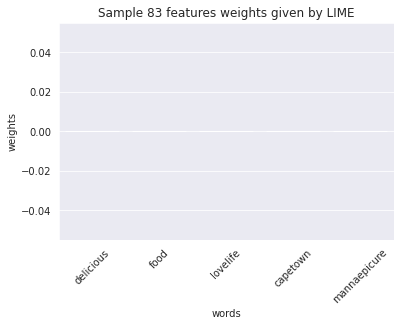

In [54]:
import lime
import sklearn
import sklearn.ensemble
import sklearn.metrics

In [55]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

In [56]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

In [57]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

RandomForestClassifier(n_estimators=500)

In [58]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

In [63]:

c.()

ValueError: ignored

In [65]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)
newsgroups_test.data[idx]

'From: johnchad@triton.unm.edu (jchadwic)\nSubject: Another request for Darwin Fish\nOrganization: University of New Mexico, Albuquerque\nLines: 11\nNNTP-Posting-Host: triton.unm.edu\n\nHello Gang,\n\nThere have been some notes recently asking where to obtain the DARWIN fish.\nThis is the same question I have and I have not seen an answer on the\nnet. If anyone has a contact please post on the net or email me.\n\nThanks,\n\njohn chadwick\njohnchad@triton.unm.edu\nor\n'

In [67]:
idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)

print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0, 1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

Document id: 83
Probability(christian) = 0.466
True class: atheism


In [ ]:
# model.compile("adam", "binary_crossentropy", metrics=["accuracy",tf.keras.metrics.AUC()])
# history=model.fit(np.asarray(tfidf_data[0]), np.asarray(train['label']), batch_size=128, epochs=1)#
